# Load data and preprocess #

### This code is for loading the data from kaggle, performing any necessary transformations, and storing the modified results in a .csv file for easier access ###

In [73]:
# Automatically load changes in dependency files (may be unnecessary here, but useful tool in case you're modifying packages that this file relies on)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First need to download the dataset from Kaggle ##
I moved the dataset to a local directory for better access to it, since the default installed in .cache/kagglehub

In [74]:

# %conda install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("goyaladi/twitter-bot-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\maden\.cache\kagglehub\datasets\goyaladi\twitter-bot-detection-dataset\versions\2


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import os

In [76]:
# Recursive find for bot data from current directory
path = None
for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if filename == "bot_detection_data.csv":
            path = os.path.join(dirpath, filename)

assert path is not None, "bot_detection_data.csv not found in current directory or any subdirectories"
print(f"Path to csv file: {path}")

Path to csv file: .\data\bot_detection_data.csv


In [77]:
# Read in data into dataframe and get some preliminary information about dataset
df = pd.read_csv(path)

print(df.dtypes)

df.head()

User ID            int64
Username          object
Tweet             object
Retweet Count      int64
Mention Count      int64
Follower Count     int64
Verified            bool
Bot Label          int64
Location          object
Created At        object
Hashtags          object
dtype: object


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [78]:
# An issue right off the bat, created at should be Unix epoch time. Convert to datetime, then to int 
df["Created At"] = pd.to_datetime(df["Created At"]).astype("int64") // 10**9 # Convert to seconds
df["Location"] = df["Location"].astype(str)
df["Hashtags"] = df["Hashtags"].astype(str)

print(df.dtypes)

User ID            int64
Username          object
Tweet             object
Retweet Count      int64
Mention Count      int64
Follower Count     int64
Verified            bool
Bot Label          int64
Location          object
Created At         int64
Hashtags          object
dtype: object


In [79]:
# Check for NaN values in the dataset
print(df.isna().sum())

User ID           0
Username          0
Tweet             0
Retweet Count     0
Mention Count     0
Follower Count    0
Verified          0
Bot Label         0
Location          0
Created At        0
Hashtags          0
dtype: int64


In [80]:
'''
Looks like data is already fairly clean, the only NaN column is hashtags
We want our model to generalize, so it should not include the User ID or Username as parameters
The bot label will need to be dropped before feeding data to the model.
'''

df = df.drop(["User ID", "Username"], axis=1)
df.head()

,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,1589210990,nan
1,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,1669439890,both live
2,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,1659928614,phone ahead
3,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,1628980025,ever quickly new I
4,Animal sign six data good or.,26,3,8438,False,1,Camachoville,1586813061,foreign mention


In [81]:
'''Our biggest problem now is the string labels - they can't be one-hot-encoded, so we will need to tokenize them.
First, create lists of the items, since Tfidf vectorizer requires an iterable.
This works for hashtags and tweets, but not locations - we will have to one-hot encode those.
'''

twt_list = df["Tweet"].tolist()
hashtag_list = df["Hashtags"].tolist()


In [82]:
''' Initialize vectorizer and fit

 Also this site helped me understand how to use this library and what it does:
 https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
 '''
vectorizer = TfidfVectorizer()


twt_document_term_matrix = vectorizer.fit_transform(twt_list)
hashtag_document_term_matrix = vectorizer.fit_transform(hashtag_list)

print(twt_document_term_matrix[0])

# More interesting case -- a lot of these which are only one word long have a score of 1.0
print(hashtag_document_term_matrix[1])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 969)>
  Coords	Values
  (0, 798)	0.28687366959472393
  (0, 10)	0.2877837013560898
  (0, 604)	0.2877837013560898
  (0, 20)	0.2883994626351018
  (0, 529)	0.2874785642452986
  (0, 473)	0.2890226878688716
  (0, 544)	0.2857828476297498
  (0, 292)	0.29050694832209273
  (0, 760)	0.29349641716850716
  (0, 275)	0.2927045243621774
  (0, 759)	0.2877837013560898
  (0, 481)	0.2863749707067641
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 970)>
  Coords	Values
  (0, 108)	0.7067291193293532
  (0, 460)	0.7074842414442578


In [83]:
''' The support vector machine will expect lists of fixed size. Currently, 
values are stored in a dense matrix, since most entries in the vocabulary are 0.
We need the full dense_matrix, although this will take up a significant amount of memory, in order to have
vectors of fixed-length to pass into the model.
'''

twt_document_term_matrix = twt_document_term_matrix.toarray()
hashtag_document_term_matrix = hashtag_document_term_matrix.toarray()

df["Tweet"] = list(twt_document_term_matrix)
df["Hashtags"] = list(hashtag_document_term_matrix)

df.head()

,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",85,1,2353,False,1,Adkinston,1589210990,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55,5,9617,True,0,Sanderston,1669439890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,2,4363,True,0,Harrisonfurt,1659928614,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,5,2242,True,1,Martinezberg,1628980025,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26,3,8438,False,1,Camachoville,1586813061,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [84]:
# Now need to one-hot encode location
label_encoder = LabelEncoder()

'''Print the length of Location before. We can see that some locations are repeated,
 but there are still 25k unique values. Some more preprocessing may be necessary here.

'''
print(f"{len(df['Location'])}")

df["Location"] = label_encoder.fit_transform(df["Location"])

df["Location"].unique()

50000


array([   85, 19263,  6482, ..., 23730,  9388,  2938], shape=(25199,))

Text(0.5, 1.0, 'Collinearity of Features')

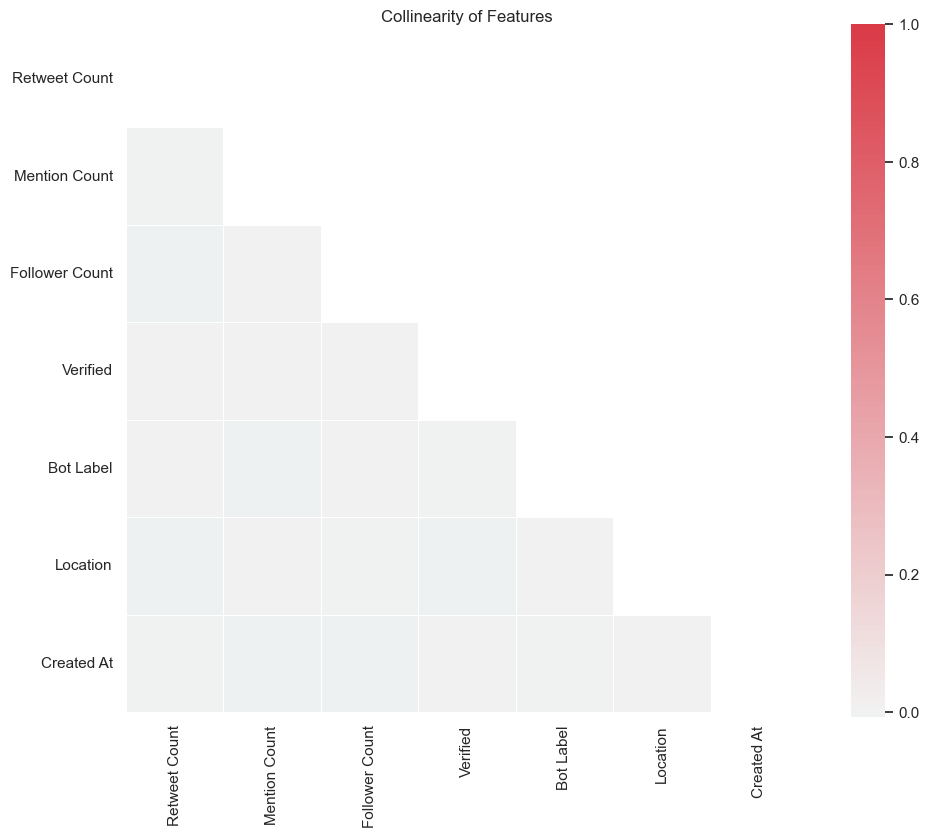

In [85]:
# Next, we check for collinearity among these features
# Source: https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14#:~:text=A%20correlation%20heatmap%20is%20a,1%20signifies%20a%20perfect%20correlation.
sns.set_theme(style="white")
# Matplotlib will not allow for multidimensional arrays to be plotted here,
# so we drop the encoded string values.
df_corr = df.drop(["Tweet", "Hashtags"], axis='columns')
corr = df_corr.corr()
mask = np.zeros_like(corr, dtype=bool) # Array of 0s with same size and dtype as corr
mask[np.triu_indices_from(mask)] = True # Upper triangle set to True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidth=.5)
ax.set_title("Collinearity of Features")

In [86]:
# Most features don't seem highly correlated, so no need to drop any (no risk here of overprioritizing certain aspects of dataset)
# Save dataset to csv file

#df.to_csv('data/preprocessed_data.csv', index=True)

# Try parquet, it is allegedly faster and will preserve data types (namely, the lists)
df.to_parquet('data/preprocessed_data.parquet')